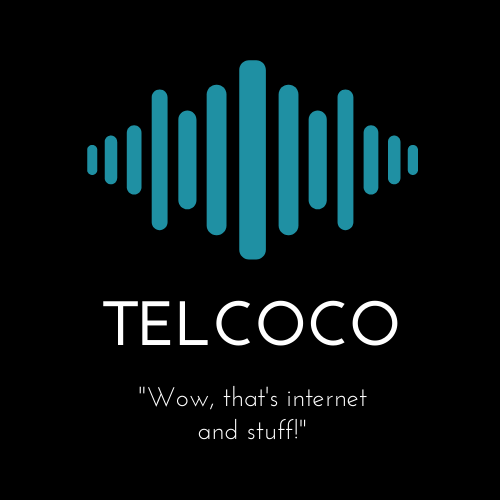

   # Classification Project Part 1 - Report

Caroline Miller

March 21, 2023

O'Neil Data Science Cohort

Goal: The purpose of this project ultimately is to provide insight, indictators, and a model which will help Telco understand why some customers are churning and what specfic features about the customer experience with the company may be contributing to their desicion to churn. The Data Science methodology used in this project is Classification.

Project Description: This project encompasses the steps of the Data Science pipeline using the Classification methodology in order to provide some explanation as to why some customers churn from using Telco services and to develop a model which can be used to predict which accounts will churn. This is important because the climate for telecommunications companies is competitive, and the rate of churn at Teclo has raised concern. This is important for any company which provides a service in an industry which is saturated with providers. Finding the aspects by which a company is failing to satisfy its customers is good for both the copmany and its customers.

### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import env
import scipy.stats as stats

from pydataset import data
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

import evaluation
import acquire
import prepare
from IPython import display

### Acquire

In [2]:
unclean_telco = ut = acquire.get_telco_data()

This dataframe is acquired using a function which imports the dataframe from MySQL. 

It joins five additional tables to the customers which results in a dataframe of 7,043 rows and 26 columns. 

Each row represents a telco customer/account, and each column represents a feature pretaining to that account/account holder. 

### Prepare

In [3]:
clean_telco = ct = prepare.prep_telco()

The prepare telco dataframe is wrangled using a function which calls the aqcuire function. The function then cleans and transforms the dataframe. 

The following changes were made to the dataframe:
    
       1. Colummns were dropped: payment_type_id, internet_service_type_id, contract_type_id, customer_id
       2. Boolean values were applied to all possible string values
       3. String values which contained numeric values were changed to int or float
       4. Columns which contained values 3 or less were transformed using pd.get_dummies()
       5. All columns which contained dates were transformed into datetime datatypes
       6. A column was added which contained the difference in date for customers who had churned 
       7. Null values in the churn_month and signup_date columns were filled with 00-00-0000 to represent that these accounts were still active. Note:  the majority of the accounts are still active, so removing them would only provide a dataset of solely customers who have churned.

### Explore

#### Initial Questions:

According to Reviews.org (https://www.reviews.org/internet-service/cost-of-internet-streaming-and-cell-phone-bills/): 

Average American monthly telecommunications costs:

    - Internet services: $57.25 per month
    - Cell phone plans: $50.17 per month
    - Streaming services: $39.96 per month
    - Total: $147.38 per month

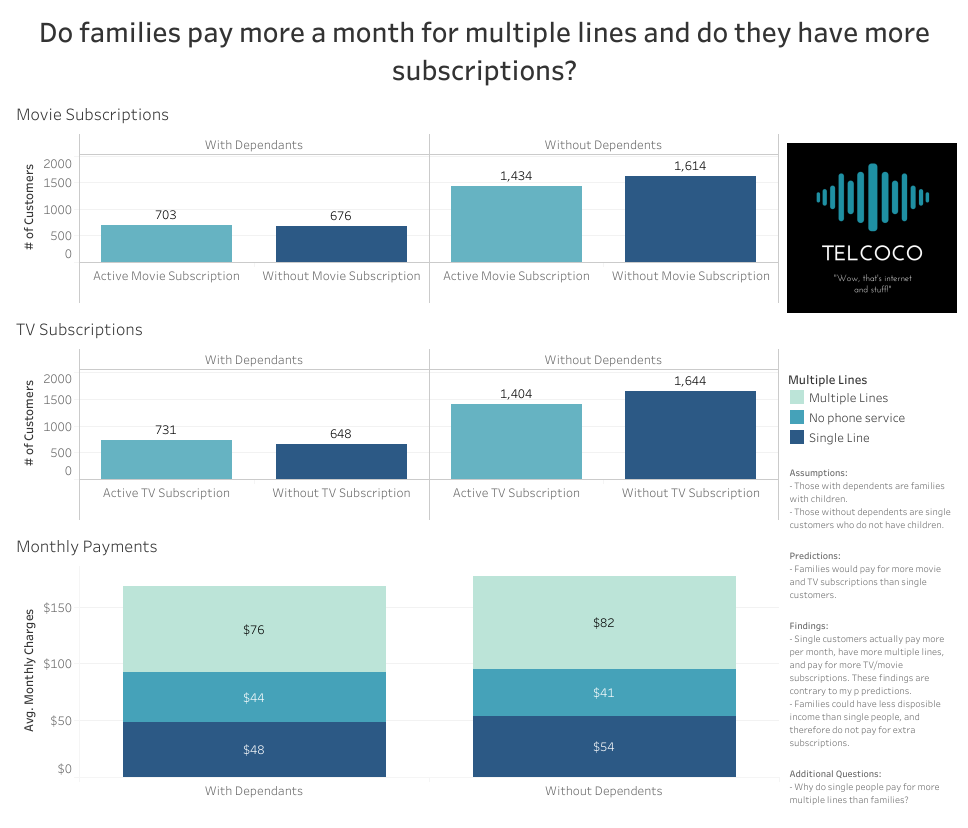

In [4]:
display.Image("/Users/carolinesmac/codeup-data-science/telco_classification_report/Dashboard 1.png")

In [42]:
all_services = filtered_ct[(filtered_ct['phone_service'] == 1) & ((filtered_ct['internet_service_type'] == 'DSL') | (filtered_ct['internet_service_type'] == 'Fiber optic')) & (filtered_ct['streaming_tv'] == 1) & (filtered_ct['streaming_movies'] == 1)]
all_services.monthly_charges.mean()

97.61183908045972

There are 1740 customers who pay for internet services (DSL or Fober Optic), phone service, tv streamiong, and movie streaming. The average these customers pay per month is $97.61, compared to the monthly average of Americans ($147.38). 

Conclusion:  Perhaps the cost fo these services is not a contributing factor to churn.

Findings from a univariate and bivariate analysis of vizualizations:
    
    1. Of customers who are senior citizens, significatnly more churn
    2. Of customers who pay for tv streaming, significantly more churn
    3. Of customers who pay for movie streaming, significantly more churn

All other inbalances in uniform distributions mirroe the ratio of the population.

Planning: My planning, question development, and exploratory analysis comes from a few realizations developed upon first glance to the dataset. Please refer to 'Dashboard 1' =, which can be found in this repository for the report to which I am refering. Upon initial exploration, I wanted to know if those who were paying for movie and tv streaming were customers who had dependents. My assumption was that these customers had families, perhaps with small children. I also assumed that these customers who had dependenst would make up the majority of the customers who paid for multiple lines. Both of these assumptions in mind, I then hypothesized that the customers with dependents would have the larger monthly and total costs and that this demographic would be less likely to churn.

The questions that are then formally expored include:

    1. What is the the relationship between having dependents and the rate of churn?

    2. If those with dependents do not make up the majority of churn, is there a group of people where the churn is greater than the those who stayed with the company? The answer to this was that senior citizens churn more than not. So the question then became is there a relationship between being a senior citizen and churn?

    3. Is the mean total charges of those who pay for internet, phone, and streaming services more than those who do not?

    4. Do those who pay for internet, phone, and streaming services have greater tenures than those who do not?

Questions 1: What is the relationship between having dependents and churn?

Text(0, 0.5, 'Rate of Churn')

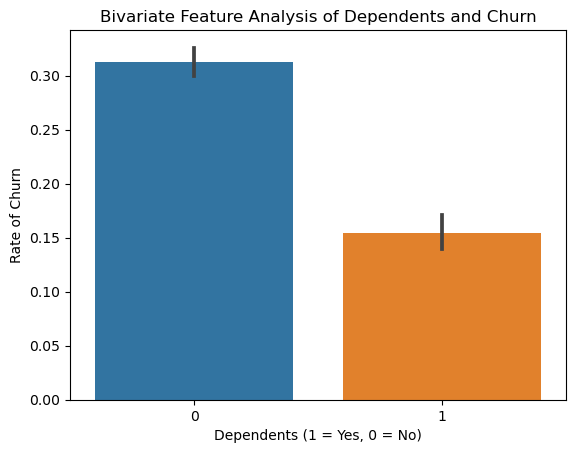

In [6]:
sns.barplot(data = ct, x = 'dependents', y = 'churn', )
plt.title('Bivariate Feature Analysis of Dependents and Churn')
plt.xlabel('Dependents (1 = Yes, 0 = No)')
plt.ylabel('Rate of Churn')

Text(0, 0.5, 'TV Streaming')

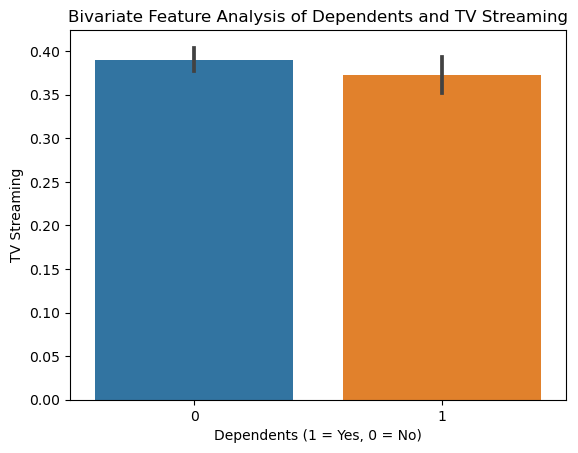

In [7]:
sns.barplot(data = ct, x = 'dependents', y = 'streaming_tv', )
plt.title('Bivariate Feature Analysis of Dependents and TV Streaming')
plt.xlabel('Dependents (1 = Yes, 0 = No)')
plt.ylabel('TV Streaming')

Text(0, 0.5, 'Movie Streaming')

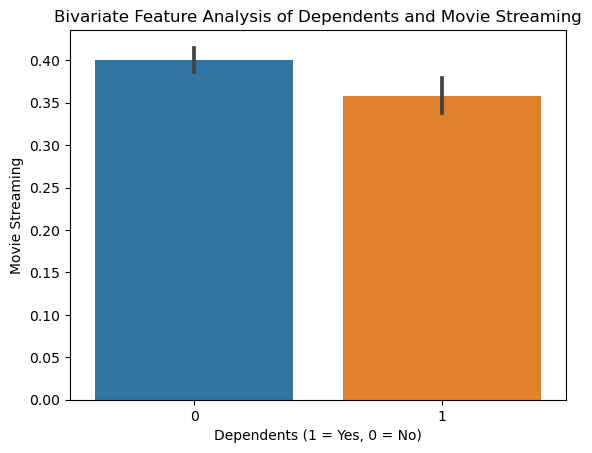

In [8]:
sns.barplot(data = ct, x = 'dependents', y = 'streaming_movies', )
plt.title('Bivariate Feature Analysis of Dependents and Movie Streaming')
plt.xlabel('Dependents (1 = Yes, 0 = No)')
plt.ylabel('Movie Streaming')

Findings:  Those with dependents and those presumably being those who would pay for these services and then churn actually did not make up the majority of those who churned nor the majority of those paying for streaming services. 

Those without dependents were the ones paying for these services and those who were churning the most.

Statistical testing to conclude if there is a relationship between having dependents and churn:

In [9]:
observed = pd.crosstab(ct.dependents, ct.churn)
observed

churn,0,1
dependents,,
0,3390,1543
1,1784,326


$H_O$: The variables with dependents and churn are independent of each other. 

$H_A$: The variables with dependents and churn are dependent upon each other. 

In [10]:
chi2, p, _, expected = stats.chi2_contingency(observed)

Setting the Confidence Level to 95%, therefore the alpha will be 5%.

In [11]:
α = 0.05

In [12]:
if p < α:
    print(f'The p value ({p}) is less than our alpha so we reject the null hypothesis, and we cannot with confidence conclude that churn and having dependents are independent of eachother.')
else:
    print(f'The p value ({p} is greater than or equal to the alpha, and therefore we fail to reject the null hypothesis and can say with confident that churn and having dependents are independent variables.')

The p value (4.9249216612154196e-43) is less than our alpha so we reject the null hypothesis, and we cannot with confidence conclude that churn and having dependents are independent of eachother.


Conclusion: So we can presume that having dependents is indicative whether or not a customer will churn. It seems like if a customer has dependents, they are more likely to NOT churn. 

Text(0, 0.5, 'Rate of Churn')

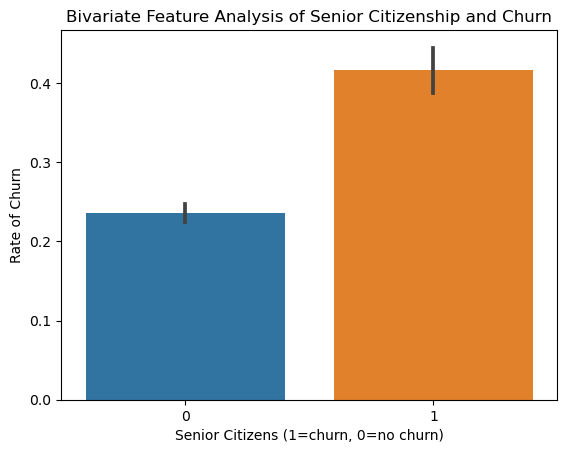

In [13]:
sns.barplot(data = ct, x = 'senior_citizen', y = 'churn', )
plt.title('Bivariate Feature Analysis of Senior Citizenship and Churn')
plt.xlabel('Senior Citizens (1=churn, 0=no churn)')
plt.ylabel('Rate of Churn')

Question 2: Is there a relationship between being a senior citizen and churning?

In [14]:
observed = pd.crosstab(ct['senior_citizen'], ct['churn'])
observed

churn,0,1
senior_citizen,,
0,4508,1393
1,666,476


$H_0$: Churn and being a senior citizen are independent of each other.

$H_A$: Churn and being a senior citizen are dependent pn each other.

In [15]:
chi2, p, _, expected = stats.chi2_contingency(observed)

In [16]:
if p < α:
    print(f'The p value ({p}) is less than our alpha so we reject the null hypothesis, and we cannot with confidence conclude that churn and being a senior citizen are independent of eachother.')
else:
    print(f'The p value ({p} is greater than or equal to the alpha, and therefore we fail to reject the null hypothesis and can say with confident that churn and being a senior citizen are independent variables.')

The p value (1.510066805092378e-36) is less than our alpha so we reject the null hypothesis, and we cannot with confidence conclude that churn and being a senior citizen are independent of eachother.


Question 3: Is the mean total charges of those who pay for internet, phone, and streaming services more than those who do not?

Statistical test of a mean comparison of the total charges between two sample groups. We are looking to see if the mean for with services is greater than those without.

Two samples, one tailed

In [17]:
# Mask of necessary columns for analysis
filtered_ct = ct[['internet_service_type', 'phone_service', 'streaming_tv', 'streaming_movies', 'churn', 'monthly_charges', 'tenure', 'total_charges']]

# Mask that isolates the accounts that pay for internet, phone, and both streaming
# services
all_services = filtered_ct[(filtered_ct['phone_service'] == 1) & ((filtered_ct['internet_service_type'] == 'DSL') | (filtered_ct['internet_service_type'] == 'Fiber optic')) & (filtered_ct['streaming_tv'] == 1) & (filtered_ct['streaming_movies'] == 1)]

# Mask of the customers not included in the above sample
not_all_services = filtered_ct[~((filtered_ct['phone_service'] == 1) & ((filtered_ct['internet_service_type'] == 'DSL') | (filtered_ct['internet_service_type'] == 'Fiber optic')) & (filtered_ct['streaming_tv'] == 1) & (filtered_ct['streaming_movies'] == 1))]

not_all_charges = not_all_services.total_charges 
all_charges = all_services.total_charges

$H_O$: The mean of total charges of those who pay for all services is less or equal to the mean of total charges of those who do not. 

$H_A$: The mean of total charges of those who pay for all services is greater than the mean of total charges of those who do not. 

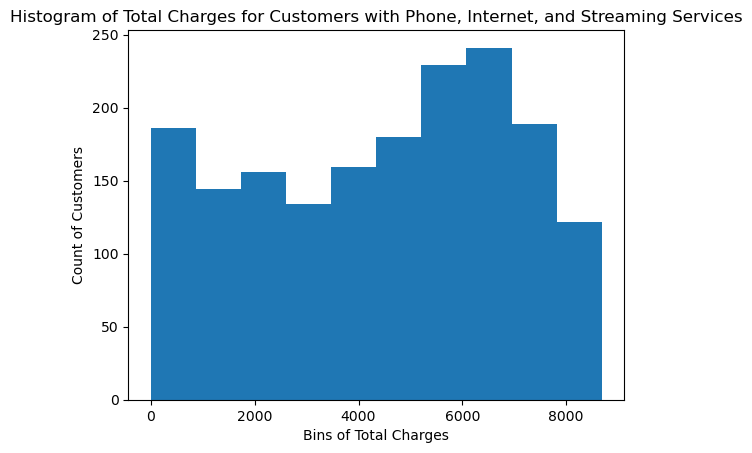

In [18]:
plt.hist(all_charges)
plt.title('Histogram of Total Charges for Customers with Phone, Internet, and Streaming Services')
plt.xlabel('Bins of Total Charges')
plt.ylabel('Count of Customers')
plt.show()

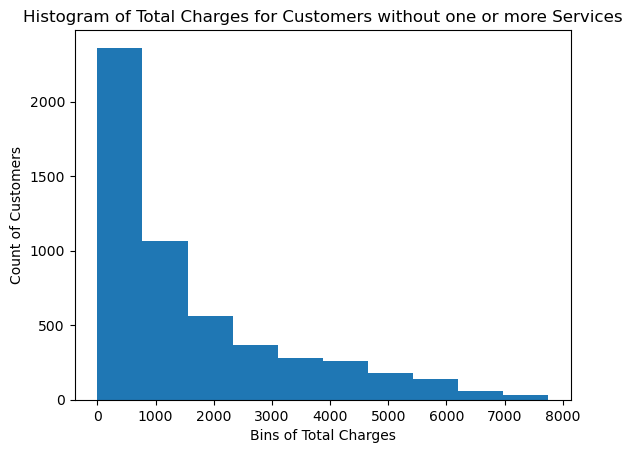

In [19]:
plt.hist(not_all_charges)
plt.title('Histogram of Total Charges for Customers without one or more Services')
plt.xlabel('Bins of Total Charges')
plt.ylabel('Count of Customers')
plt.show()

$H_O$: Total charges for both samples have equal variance.

$H_A$: Total charges for both samples do NOT have equal variance.

In [20]:
t_stat, p_val = stats.levene(not_all_charges, all_charges)

In [21]:
if p_val < α:
    print(f'With a p value of {p_val}, we must reject the null hypothesis; we cannot presume that these samples have equal variance.')
else:
    print(f'With a p value of {p_val}, we fail to reject the null hypothesis; we can presume that these samples have equal variance.')

With a p value of 2.754935227098051e-124, we must reject the null hypothesis; we cannot presume that these samples have equal variance.


The two samples do not have equal variance, therefore the means of these groups cannor be compared to see if the chrages of those who pay for all services is greater than that of those who do not.

In [22]:
not_all_charges = not_all_services.total_charges 
all_charges = all_services.total_charges

print(not_all_charges.mean())
all_charges.mean()

1566.8348764850048


4452.438706896554

We can observe though that the average total charges paid by customers who pay for all services is significantly higher than that of those who do not.

Question 4: Do those who pay for internet, phone, and streaming services have greater tenures than those who do not?

Two independent samples, mean comparison testing, one tailed

Text(0, 0.5, 'Number of Accounts')

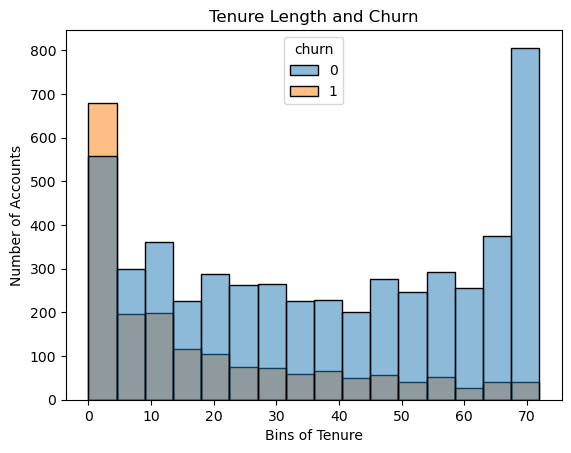

In [23]:
sns.histplot(data=ct, x='tenure', hue='churn')
plt.title('Tenure Length and Churn')
plt.xlabel('Bins of Tenure')
plt.ylabel('Number of Accounts')

In [24]:
not_all_tenure = not_all_services.tenure
all_tenure = all_services.tenure

$H_O$: The mean of tenure of those who pay for all services is more than or equal to the mean of total charges of those who do not. 

$H_A$: The mean of tenure of those who pay for all services is less than the mean of total charges of those who do not. 

Hypotheses for Levene testing:
    
    $H_O$: Tenure for both samples have equal variance.

    $H_A$: Tenure for both samples do NOT have equal variance.

In [25]:
t_stat, p_val = stats.levene(not_all_tenure, all_tenure)

In [26]:
if p_val < α:
    print(f'With a p value of {p_val}, we must reject the null hypothesis; we cannot presume that these samples have equal variance.')
else:
    print(f'With a p value of {p_val}, we fail to reject the null hypothesis; we can presume that these samples have equal variance.')

With a p value of 0.20602411457054742, we fail to reject the null hypothesis; we can presume that these samples have equal variance.


In [27]:
t_stat, p = stats.ttest_ind(not_all_tenure, all_tenure, equal_var=True)

In [28]:
if (p / 2 < α) and (t_stat < 0):
    print(f'With a p value of {p} and a t_statistic of {t_stat} which is less than 0, we must reject the null hypothesis; we cannot presume that the tenure of those who pay for all services is greater than or equal the tenure of those who do not pay for all services.')
else:
    print(f'With a p value of {p_val}, we fail to reject the null hypothesis; we can presume that these samples have equal variance.')

With a p value of 4.946213374299674e-137 and a t_statistic of -25.476763548310927 which is less than 0, we must reject the null hypothesis; we cannot presume that the tenure of those who pay for all services is greater than or equal the tenure of those who do not pay for all services.


Conclusion: Those who pay for all services do not stay with the company for longer than those who do not pay for all services. Paying for the streaming services as well as internet and phone could be a indicative feature for churn 

#### Exploration Summary:

Contrary to my hypothesis, it can be said with some confidence that there is a relationship between having dependents and churn, though this relationship does not appear to be as indicative of senior citizenship to the probabilty of churn. 

My attempt to compare the mean total charges of those who pay for all four services (phone, internet, and both streaming services) to those who do not proved to be impossible due to unequal variance.

What may have been a strong assumption can be supported by the rejection of the null hypothesis in regards to the tenure of those who pay for all four services listed above. Those who pay for these services tend to stay with the company for less time than those who do not pay for all four services.

The four services, along with tenure, senior citizenship, and dependents will then be used as subset in the modeling stage, as these features have proven some relation to churn. Total charges will not be included as it is not a comparable feature.

### Modeling

#### Baseline Model:

Churn:     1869

No Churn:  5174

In [29]:
# Making a modeling dataframe which contains only int and float types for 
# algorithmic computing purposes.
modeling_ct = ct.drop(columns=(['signup_date', 'time_with_telco', 'gender', 'contract_type', 'internet_service_type', 'payment_type', 'churn_month']))

In [30]:
# Creating the baseline model predictions with the more common 0 value of no churn
modeling_ct['baseline'] = 0

In [31]:
# Splitting the dataframe into the train, test, and validate datasets using the 
# split data function from the prepare module.
train, test, validate = prepare.split_data(modeling_ct, 'churn')

(7043, 26)
(5634, 26)
(1409, 26)


In [32]:
X_cols = train.columns.to_list()
y_cols = 'churn'

# Then we will take the target column out of the features list
X_cols.remove('churn')
X_cols.remove('customer_id')

# now lets sparse our datasets with the correct columns

X_train = train[X_cols]
y_train = train[y_cols]
X_val = validate[X_cols]
y_val = validate[y_cols]
X_test = test[X_cols]
y_test = test[y_cols]

#### Baseline Evaluation Metrics

In [33]:
print(evaluation.get_metrics(y_train, train.baseline, train))
print(evaluation.conf_matrix(y_train, train.baseline))
evaluation.class_report(y_train, train.baseline)


    Accuracy: 0.7347197565305605
    True Positive Rate: 0.7347197565305605
    True Negative Rate: nan
    False Positive Rate: nan
    False Negative Rate: 0.2652802434694395
    Precision : 1.0
    f1 score: 0.8470760233918129
    supports: 0: 2897 1: 1046
    
None
                        pred_0             pred_1
actual_0   True Positive: 2897  False Positive: 0
actual_1  False Positive: 1046   True Negative: 0


,0,1,accuracy,macro avg,weighted avg
precision,0.734720,0.0,0.73472,0.367360,0.539813
recall,1.000000,0.0,0.73472,0.500000,0.734720
f1-score,0.847076,0.0,0.73472,0.423538,0.622363
support,2897.000000,1046.0,0.73472,3943.000000,3943.000000


####  Models to be further evaluated:

    From the Random Forest:
    
        - RandomForestClassifier(max_depth=8, min_samples_leaf=3)(3, 8)_model
    
    From the Decision Tree:
        - DecisionTreeClassifier(max_depth=3)	
    
    From Logistic Regression: 
        - lr1

Note:  Please see the inclusion of the subset in the Logistic Regression model testing portion of the 'telco_classification_pipeline' Jupyter Notebook. It is significant to state that the models using the features which I concluded were related to churn actually performed worse than the model which used all of the numeric features.

In [34]:
# Creating three models based off modeling evaluation (please see telco_classification_pipeline)
rf3_8 = RandomForestClassifier()
rf3_8.fit(X_train, y_train)

dt3 = DecisionTreeClassifier()
dt3.fit(X_train, y_train)

lr1 = LogisticRegression()
lr1.fit(X_train, y_train)

LogisticRegression()

Random Forest (max_depth=8, min_samples_leaf=3)

In [35]:
# Calculating y predictions based off of the train dataset
rf3_8_train_preds = rf3_8.predict(X_train)

# Calculating the y predictions off of the validate dataset
rf3_8_val_preds = rf3_8.predict(X_val)

Decision Tree (max_depth=3)

In [36]:
# Calculating y predictions based off of the train dataset
dt3_train_preds = dt3.predict(X_train)

# Calculating the y predictions off of the validate dataset
dt3_val_preds = dt3.predict(X_val)

Logisitic Regression 1

In [37]:
# Calculating y predictions based off of the train dataset
lr1_train_preds = lr1.predict(X_train)

# Calculating the y predictions off of the validate dataset
lr1_val_preds = lr1.predict(X_val)

In [38]:
print()
print('        Evaluation Metrics on the Train Dataset')
print('_____________________________________________________________')
print()
print('    Random Forest Model, max_depth=8, min_samples_leaf=3:')
print('_____________________________________________________________')
print(evaluation.get_metrics(y_train, rf3_8_train_preds, train))
print('_____________________________________________________________')
print('_____________________________________________________________')
print()
print('                 Decision Tree , max_depth=3')
print('_____________________________________________________________')
print(evaluation.get_metrics(y_train, dt3_train_preds, train))
print('_____________________________________________________________')
print('_____________________________________________________________')
print()
print('                  Logistic Regression Model')
print('_____________________________________________________________')
print(evaluation.get_metrics(y_train, lr1_train_preds, train))


        Evaluation Metrics on the Train Dataset
_____________________________________________________________

    Random Forest Model, max_depth=8, min_samples_leaf=3:
_____________________________________________________________

    Accuracy: 0.9982247020035506
    True Positive Rate: 0.9975895316804407
    True Negative Rate: 1.0
    False Positive Rate: 0.0
    False Negative Rate: 0.0024104683195592287
    Precision : 1.0
    f1 score: 0.9987933114980176
    supports: 0: 2897 1: 1046
    
None
_____________________________________________________________
_____________________________________________________________

                 Decision Tree , max_depth=3
_____________________________________________________________

    Accuracy: 0.9982247020035506
    True Positive Rate: 0.9975895316804407
    True Negative Rate: 1.0
    False Positive Rate: 0.0
    False Negative Rate: 0.0024104683195592287
    Precision : 1.0
    f1 score: 0.9987933114980176
    supports: 0: 2897 1: 104

In [39]:
print()
print('        Evaluation Metrics on the Validate Dataset')
print('_____________________________________________________________')
print()
print('    Random Forest Model, max_depth=8, min_samples_leaf=3:')
print('_____________________________________________________________')
print(evaluation.get_metrics(y_val, rf3_8_val_preds, validate))
print('_____________________________________________________________')
print('_____________________________________________________________')
print()
print('                 Decision Tree , max_depth=3')
print('_____________________________________________________________')
print(evaluation.get_metrics(y_val, dt3_val_preds, validate))
print('_____________________________________________________________')
print('_____________________________________________________________')
print()
print('                  Logistic Regression Model')
print('_____________________________________________________________')
print(evaluation.get_metrics(y_val, lr1_val_preds, validate))


        Evaluation Metrics on the Validate Dataset
_____________________________________________________________

    Random Forest Model, max_depth=8, min_samples_leaf=3:
_____________________________________________________________

    Accuracy: 0.7823772915434654
    True Positive Rate: 0.8251488095238095
    True Negative Rate: 0.6167146974063401
    False Positive Rate: 0.38328530259365995
    False Negative Rate: 0.17485119047619047
    Precision : 0.892914653784219
    f1 score: 0.8576952822892497
    supports: 0: 1242 1: 449
    
None
_____________________________________________________________
_____________________________________________________________

                 Decision Tree , max_depth=3
_____________________________________________________________

    Accuracy: 0.722649319929036
    True Positive Rate: 0.8234309623430962
    True Negative Rate: 0.4798387096774194
    False Positive Rate: 0.5201612903225806
    False Negative Rate: 0.17656903765690377
    Preci

#### Evaluation of Models:

The positive value in these tests is 0, which is not the value in question. The question is that of churn which is the negative value and of the model's ability to predict churn. For this reason, I concluded to use precision as the evaluation metric for which to choose the best performing model. The best performing model by this standard is the Random Forest. 

In [40]:
# Calculating the predictions on the test dataset
rf3_8_test_preds = rf3_8.predict(X_test)

In [41]:
# Using the evaluation module to calculate and print the metrics.
print(evaluation.get_metrics(y_test, rf3_8_test_preds, test))
print(evaluation.conf_matrix(y_test, rf3_8_test_preds))
evaluation.class_report(y_test, rf3_8_test_preds)


    Accuracy: 0.7764371894960965
    True Positive Rate: 0.8302752293577982
    True Negative Rate: 0.5924764890282131
    False Positive Rate: 0.40752351097178685
    False Negative Rate: 0.16972477064220184
    Precision : 0.8743961352657005
    f1 score: 0.8517647058823529
    supports: 0: 1035 1: 374
    
None
                       pred_0               pred_1
actual_0   True Positive: 905  False Positive: 130
actual_1  False Positive: 185   True Negative: 189


,0,1,accuracy,macro avg,weighted avg
precision,0.830275,0.592476,0.776437,0.711376,0.767155
recall,0.874396,0.505348,0.776437,0.689872,0.776437
f1-score,0.851765,0.545455,0.776437,0.698610,0.770459
support,1035.000000,374.000000,0.776437,1409.000000,1409.000000


### Conclusions:

The questions that were formally expored include:

    1. What is the the relationship between having dependents and the rate of churn?
    2. Is there a relationship between being a senior citizen and churn?
    3. Is the mean total charges of those who pay for internet, phone, and streaming services more than those who do not?
    4. Do those who pay for internet, phone, and streaming services have greater tenures than those who do not?
    
We did see a relationship between being a senior citizen and churn as well as having dependents and churn. I hypothesized that using these features in my subset would produce higher precision of churn predictions. I conclude that ,because the models using this subset performed worse than the models which used all the numeric features, I did not isolate the most indictaive feature or features in the exploratory phase.   

### Recommendations:

I would recommend targeting those customers without dependents to identify the possiible reasons that they churn. This group contains the majority of customers who pay for multiple lines, TV streaming, and movie streaming. It is possible that this group is dissatified with some of the services for which they pay extra (those without dependents who pay for these services on average pay $7.48 more). 

### Next Steps:

I would still like to explore the initial questions I had about this dataset which include: 

    Why do those who no dependents have more multiple lines than those with dependents? Because we saw that those wihtout dependents churn more and that those with multiple lines churn more, is there a feature shared by both which is related to churn?
    
    Why do those who pay for TV and movie streaming churn more? 
    
There are more demographics to be sparsed out and explored which may result in finding the group which shares a specific compilation of features which churns more than others. A greater multivariate analysis needs to be run on this dataset. 

An analysis on the datetime data is necessary to find if there is a specific month or season which customers churn, or if the difference between the signup date and the churn month has any significance. 